# __EXP#4__

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, random_split, DataLoader
from sklearn.metrics import mean_squared_error
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation
from itertools import combinations
import matplotlib.pyplot as plt

In [2]:
# predicted variable --- the Fame/Popularity of US presidents
# source: https://today.yougov.com/ratings/politics/popularity/US-presidents/all

In [3]:
dfx = pd.read_csv('../dataset/final_dataset.csv', index_col=0)
dfy = pd.read_csv('../dataset/presidents_impression.csv', index_col=0)
pd.merge(dfx, dfy[['Popularity_rank']], how='inner', right_index=True, left_index=True)

,Convention Flexibility,Convention Self-Variation,Convention Uniquiality,Inaugural Flexibility,Inaugural Self-Variation,Inaugural Uniquiality,Money Flexibility,Money Self-Variation,Money Uniquiality,Policy Flexibility,...,War Uniquiality,Commemoration Flexibility,Commemoration Self-Variation,Commemoration Uniquiality,FP Flexibility,FP Self-Variation,FP Uniquiality,Voice Uniquiality,Appearance Uniquiality,Popularity_rank
Name,,,,,,,,,,,,,,,,,,,,,
George W. Bush,41.963068,0.000000,156.316661,91.163403,26.522341,280.073096,63.339522,52.034337,733.866416,93.294775,...,1797.732470,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.665312,62.245352,7
Barack Obama,71.388267,20.881308,179.073752,166.842064,74.655594,126.666501,71.539576,52.799312,725.937721,76.573724,...,882.965973,90.629421,32.584004,225.831136,76.629796,48.393789,625.668053,2.634852,86.529328,3
Franklin D. Roosevelt,37.978765,26.335900,1064.928622,46.311804,19.095730,993.668624,80.563927,38.353601,2876.531394,23.875283,...,2882.403214,56.076715,0.000000,236.751473,39.538675,0.000000,360.122575,2.579798,74.013612,2
Bill Clinton,49.909986,0.000000,114.767508,117.687859,30.878925,258.967024,73.534707,0.000000,229.038166,142.925798,...,298.768157,108.169685,47.753979,307.994535,95.176756,71.077472,840.151625,2.805069,69.285616,6
George H. W. Bush,76.816752,29.545347,165.197555,60.667146,0.000000,179.463535,77.439913,0.000000,180.110887,70.635364,...,407.865949,0.000000,0.000000,0.000000,141.322633,77.252000,249.978195,2.443584,47.247439,9
Richard M. Nixon,0.000000,0.000000,0.000000,146.533239,32.168691,213.700817,0.000000,0.000000,0.000000,0.000000,...,626.337948,0.000000,0.000000,0.000000,64.094845,0.000000,194.186568,2.596285,47.460769,10
John F. Kennedy,57.125283,0.000000,245.135543,79.157434,0.000000,130.122863,118.118226,63.395335,241.470377,61.365290,...,0.000000,70.143155,32.582140,688.969353,116.187242,74.877436,1376.853760,2.640060,58.329489,1
Lyndon B. Johnson,66.683795,0.000000,187.874678,104.923096,0.000000,141.733688,0.000000,0.000000,0.000000,211.010619,...,615.940220,64.793554,0.000000,225.898080,77.504249,57.889252,1031.208030,2.699089,83.606348,8
Jimmy Carter,179.647577,0.000000,120.243353,147.864721,0.000000,122.888342,100.883498,0.000000,164.128845,140.076809,...,0.000000,0.000000,0.000000,0.000000,261.470804,78.437732,418.727649,2.866423,49.604996,4


In [4]:
# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, xpath, ypath='../dataset/presidents_impression.csv', y_name='Popularity_rank'):
        # load the csv file as a dataframe
        dfx = pd.read_csv(xpath, index_col=0)
        dfy = pd.read_csv(ypath, index_col=0)
        df = pd.merge(dfx, dfy[[y_name]], how='inner', right_index=True, left_index=True)
        # store the name of features
        self.features = df.columns[:-1]
        # store the inputs and outputs
        self.X = df.iloc[:, :-1].values.astype('float32')
        self.y = df[y_name].values.astype('float32')
        # ensure target has the right shape
        self.y = self.y.reshape((len(self.y), 1))
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

In [5]:
# prepare the dataset
def prepare_data(path, p_test=0.2):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits(p_test)
    # prepare data loaders
    train_dl = DataLoader(train, shuffle=True)
    test_dl = DataLoader(test)
    return train_dl, test_dl

In [6]:
# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = nn.MarginRankingLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    # enumerate epochs
    for epoch in range(100):
        # enumerate mini batches
        for i, (inputs1, targets1) in enumerate(train_dl):
            for j, (inputs2, targets2) in enumerate(train_dl):
                # clear the gradients
                optimizer.zero_grad()
                # compute the model output
                yhat1 = model(inputs1)
                yhat2 = model(inputs2)
                # relative position
                if targets1 > targets2:
                    targets = torch.Tensor([1])
                elif targets1 < targets2:
                    targets = torch.Tensor([-1])
                else:
                    targets = torch.Tensor([0])
                # calculate loss
                loss = criterion(yhat1, yhat2, targets)
                # print(yhat1, yhat2, targets, loss)
                # credit assignment
                loss.backward()
                # update model weights
                optimizer.step()

In [7]:
# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = nn.Linear(n_inputs, 7)
        nn.init.xavier_uniform_(self.hidden1.weight)
        self.act1 = nn.Sigmoid()
        # second hidden layer
        self.hidden2 = nn.Linear(7, 3)
        nn.init.xavier_uniform_(self.hidden2.weight)
        self.act2 = nn.Sigmoid()
        # third hidden layer and output
        self.hidden3 = nn.Linear(3, 1)
        nn.init.xavier_uniform_(self.hidden3.weight)
 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        return X

In [8]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    return predictions, actuals

In [9]:
path = '../dataset/final_dataset.csv'
train_dl, test_dl = prepare_data(path, p_test=0)
print(len(train_dl.dataset), len(test_dl.dataset), )

10 0


In [10]:
# initialize the model
while True:
    model = MLP(len(train_dl.dataset.dataset.features))
    # train the model
    train_model(train_dl, model)
    # evaluate model performace
    predictions, actuals = evaluate_model(train_dl, model)
    sorted_predictions = predictions.copy()
    sorted_predictions.sort(axis=0)
    predicted_rank = [np.where(predictions == num)[0][0] + 1 for num in sorted_predictions]
    correct = 0
    total = 0
    actual_pair = list(combinations(actuals.flatten(), 2))
    predicted_pair = list(combinations(predicted_rank, 2))
    for pair1 in actual_pair:
        for pair2 in predicted_pair:
            rank1 = 1 if pair1[0] > pair1[1] else 0
            rank2 = 1 if pair2[0] > pair2[1] else 0
            if rank1 == rank2:
                correct += 1
            total += 1
    if correct / total * 100 >= 64:
        print(f'Correctly predicted pairwise position: {correct / total * 100}%')
        break

Correctly predicted pairwise position: 66.07407407407408%


In [12]:
# attribute interpretation
ig1 = IntegratedGradients(model)
ig_attr_test1 = ig1.attribute(torch.Tensor(train_dl.dataset.dataset.X), n_steps=50)
ig_attr_test_sum1 = ig_attr_test1.detach().numpy().sum(0)
ig_attr_test_norm_sum1 = ig_attr_test_sum1 / np.linalg.norm(ig_attr_test_sum1, ord=1)

In [172]:
# x_axis_data = np.arange(train_dl.dataset.dataset.X.shape[1])
# x_axis_data_labels = list(map(lambda idx: CSVDataset(path).features[idx], x_axis_data))
# plt.style.use(['nature', 'science', 'no-latex'])
# plt.rcParams['font.family'] = 'Times New Roman'

# plt.figure(figsize=(20, 8))
# ax = plt.subplot()
# ax.set_ylabel('Attributions', fontsize=15)
# ax.bar(x_axis_data, ig_attr_test_norm_sum, 0.5, align='center', alpha=0.8, color='#eb5e7c')
# plt.xticks(x_axis_data, x_axis_data_labels, rotation = 90)
# plt.tick_params(axis='both', which='major', labelsize=15)
# plt.show()

In [14]:
dl1 = DeepLift(model)
dl_attr_test1 = dl1.attribute(torch.Tensor(train_dl.dataset.dataset.X))
dl_attr_test_sum1 = dl_attr_test1.detach().numpy().sum(0)
dl_attr_test_norm_sum1 = dl_attr_test_sum1 / np.linalg.norm(dl_attr_test_sum1, ord=1)

In [15]:
ig_nt1 = NoiseTunnel(ig1)
ig_nt_attr_test1 = ig_nt1.attribute(torch.Tensor(train_dl.dataset.dataset.X))
ig_nt_attr_test_sum1 = ig_nt_attr_test1.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum1 = ig_nt_attr_test_sum1 / np.linalg.norm(ig_nt_attr_test_sum1, ord=1)

In [191]:
path = '../dataset/final_embedding.csv'
train_dl, test_dl = prepare_data(path, p_test=0)
while True:
    model = MLP(len(train_dl.dataset.dataset.features))
    train_model(train_dl, model)
    predictions, actuals = evaluate_model(train_dl, model)
    sorted_predictions = predictions.copy()
    sorted_predictions.sort(axis=0)
    predicted_rank = [np.where(predictions == num)[0][0] + 1 for num in sorted_predictions]
    correct = 0
    total = 0
    actual_pair = list(combinations(actuals.flatten(), 2))
    predicted_pair = list(combinations(predicted_rank, 2))
    for pair1 in actual_pair:
        for pair2 in predicted_pair:
            rank1 = 1 if pair1[0] > pair1[1] else 0
            rank2 = 1 if pair2[0] > pair2[1] else 0
            if rank1 == rank2:
                correct += 1
            total += 1
    if correct / total * 100 >= 64:
        print(f'Correctly predicted pairwise position: {correct / total * 100}%')
        break

Correctly predicted pairwise position: 80.24691358024691%


In [190]:
from itertools import combinations
correct = 0
total = 0
actual_pair = list(combinations(actuals.flatten(), 2))
predicted_pair = list(combinations(predicted_rank, 2))
for pair1 in actual_pair:
    for pair2 in predicted_pair:
        rank1 = 1 if pair1[0] > pair1[1] else 0
        rank2 = 1 if pair2[0] > pair2[1] else 0
        if rank1 == rank2:
            correct += 1
        total += 1
print(f'Correctly predicted pairwise position: {correct / total * 100}%')

Correctly predicted pairwise position: 50.617283950617285%


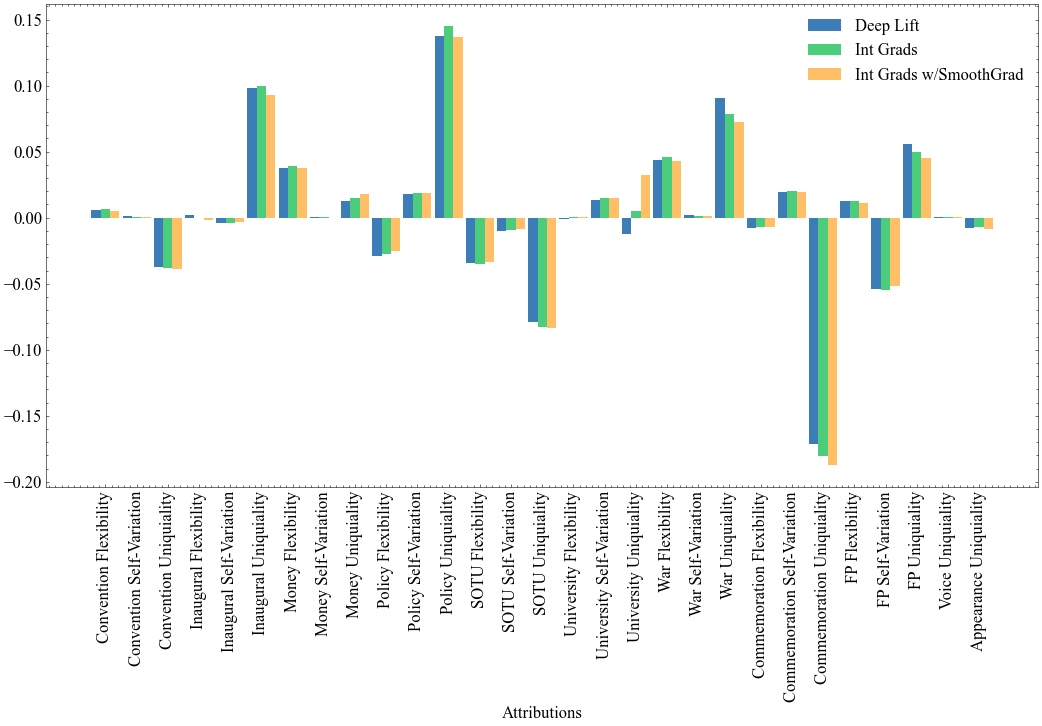

In [16]:
path = '../dataset/final_dataset.csv'
train_dl, test_dl = prepare_data(path, p_test=0)
x_axis_data = np.arange(train_dl.dataset.dataset.X.shape[1])
x_axis_data_labels = list(map(lambda idx: CSVDataset(path).features[idx], x_axis_data))

plt.style.use(['nature', 'science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'

fig, axis = plt.subplots(figsize=(16, 8), dpi=80)

legends = ['Deep Lift', 'Int Grads', 'Int Grads w/SmoothGrad']

axis.set_xlabel('Attributions', fontsize=15)
axis.bar(x_axis_data, dl_attr_test_norm_sum1, 0.3, align='center', alpha=0.8)
axis.bar(x_axis_data+0.3, ig_attr_test_norm_sum1, 0.3, align='center', alpha=0.7)
axis.bar(x_axis_data+0.6, ig_nt_attr_test_norm_sum1, 0.3, align='center', alpha=0.6)
axis.set_xticks(x_axis_data+0.3)
axis.set_xticklabels(x_axis_data_labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legends, loc='upper right', fontsize=15)
plt.show()